In [7]:
from uproot_io import Events, View
import numpy as np
from numpy import *
import matplotlib
import matplotlib.pyplot as plt
titlesize = 20
labelsize = 14

In [104]:
events = Events(r"C:\Users\andre\Desktop\Physics Project\bigdata\CheatedRecoFile_1.root")

In [91]:
def connectiondist(event_number):
    totals = []
    parts = []
    
    idx = np.where(events.event_number == event_number)[0]
    newidx = idx - idx[0]
    for i in newidx:
        x = events.reco_hits_x_w[i+idx[0]]
        z = events.reco_hits_w[i+idx[0]]
        part = events.mc_pdg[i+idx[0]]
        
        if part != 0:
            if (len(x)-1) != 0:
                total_distance = 0.0
                for j in range(len(x) - 1):
                    distance = np.sqrt((x[j+1] - x[j])**2 + (z[j+1] - z[j])**2)
                    total_distance += distance
                meandist = total_distance/(len(x)-1)
                totals.append(meandist)
                parts.append(part)
    
    return np.array(totals), np.array(parts)

In [92]:
connectiondist(1)

(array([ 3.68077233, -0.        ,  0.55904063,  1.34243729,  0.51520276]),
 array([  22,   22,  211, 2212,   13]))

In [100]:
def histplot(num, extra):
    tracks = []
    showers = []
    
    for n in range(num):
        total, part = connectiondist(n+extra)
        for i in range(len(total)):
            if total[i] != 0. and total[i] != -0. and total[i] <= 20:
                if part[i] == 22. or part[i] == -11. or part[i] == 11.:
                    showers.append(total[i])
                else:
                    tracks.append(total[i]) 
    
    #newshowers = [x for x in showers if x > 2]
    
    bin_edges = np.arange(0, 15.5, 0.5)
    hist1, _ = np.histogram(tracks, bins=bin_edges)
    hist2, _ = np.histogram(showers, bins=bin_edges)
   
    hist1_normalized = hist1 / len(tracks)
    hist2_normalized = hist2 / len(showers)

    plt.bar(bin_edges[:-1], hist1_normalized, width=0.5, align='edge', alpha=0.75, label='Tracks')
    plt.bar(bin_edges[:-1], hist2_normalized, width=0.5, align='edge', alpha=0.75, label='Showers')
    
    plt.xlabel('Mean Connection Distance')
    plt.legend()
    plt.show()

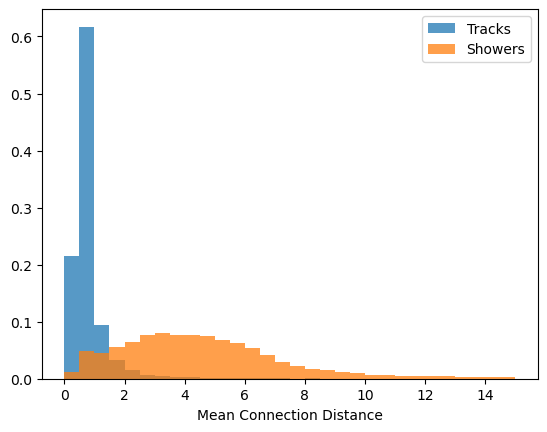

In [105]:
histplot(9000, 0)